# SKU-110K: Dataset Analysis

### 1. Initial Setup and Authentication

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import storage

### 2. Configure Project and Storage Client

In [2]:
# Set up GCP project
PROJECT_ID = 'shelfscout'
BUCKET_NAME = 'sku-110k-dataset'

# Initialize storage client
storage_client = storage.Client(project=PROJECT_ID)
bucket = storage_client.get_bucket(BUCKET_NAME)

### 3. Analyze Current Distribution

In [3]:
# Define the dataset paths
train_path = 'SKU110K_Kaggle/images/train/'
val_path = 'SKU110K_Kaggle/images/val/'
test_path = 'SKU110K_Kaggle/images/test/'

# Function to count files in a GCS path
def count_files(prefix):
    blobs = list(bucket.list_blobs(prefix=prefix))
    return len([blob for blob in blobs if not blob.name.endswith('/')])

# Count images in each split
train_count = count_files(train_path)
val_count = count_files(val_path)
test_count = count_files(test_path)

# Calculate total and percentages
total_images = train_count + val_count + test_count
train_percent = (train_count / total_images) * 100
val_percent = (val_count / total_images) * 100
test_percent = (test_count / total_images) * 100

# Display results
print(f"Dataset Distribution Analysis:")
print(f"--------------------------------")
print(f"Train images: {train_count} ({train_percent:.2f}%)")
print(f"Validation images: {val_count} ({val_percent:.2f}%)")
print(f"Test images: {test_count} ({test_percent:.2f}%)")
print(f"--------------------------------")
print(f"Total images: {total_images}")

Dataset Distribution Analysis:
--------------------------------
Train images: 8185 (70.02%)
Validation images: 584 (5.00%)
Test images: 2920 (24.98%)
--------------------------------
Total images: 11689


### 4. Check Annotation Files

In [4]:
# Function to count annotation files
def count_annotation_files(prefix):
    blobs = list(bucket.list_blobs(prefix=prefix))
    return len([blob for blob in blobs if not blob.name.endswith('/')])

# Count annotation files
train_annot_count = count_annotation_files('SKU110K_Kaggle/labels/train/')
val_annot_count = count_annotation_files('SKU110K_Kaggle/labels/val/')
test_annot_count = count_annotation_files('SKU110K_Kaggle/labels/test/')

# Check if annotations match images
print("\nAnnotation files check:")
print(f"Train: {train_annot_count} annotations for {train_count} images")
print(f"Validation: {val_annot_count} annotations for {val_count} images")
print(f"Test: {test_annot_count} annotations for {test_count} images")

# Check if there's a mismatch
if train_count != train_annot_count or val_count != val_annot_count or test_count != test_annot_count:
    print("WARNING: Number of annotation files doesn't match number of images")
else:
    print("Annotation files match image counts for all splits")


Annotation files check:
Train: 8185 annotations for 8185 images
Validation: 584 annotations for 584 images
Test: 2920 annotations for 2920 images
Annotation files match image counts for all splits


### 5. Sample Image Inspection

In [5]:
# Function to list a sample of images from each split
def sample_images(prefix, n=5):
    blobs = list(bucket.list_blobs(prefix=prefix))
    image_blobs = [blob for blob in blobs if not blob.name.endswith('/') 
                  and blob.name.lower().endswith(('.jpg', '.jpeg', '.png'))]
    return image_blobs[:min(n, len(image_blobs))]

# Get samples
train_samples = sample_images(train_path)
val_samples = sample_images(val_path)
test_samples = sample_images(test_path)

# Print sample image names
print("Sample training images:")
for blob in train_samples:
    print(f" - {blob.name}")

print("\nSample validation images:")
for blob in val_samples:
    print(f" - {blob.name}")

print("\nSample test images:")
for blob in test_samples:
    print(f" - {blob.name}")

Sample training images:
 - SKU110K_Kaggle/images/train/train_0.jpg
 - SKU110K_Kaggle/images/train/train_1.jpg
 - SKU110K_Kaggle/images/train/train_10.jpg
 - SKU110K_Kaggle/images/train/train_100.jpg
 - SKU110K_Kaggle/images/train/train_1000.jpg

Sample validation images:
 - SKU110K_Kaggle/images/val/val_0.jpg
 - SKU110K_Kaggle/images/val/val_1.jpg
 - SKU110K_Kaggle/images/val/val_10.jpg
 - SKU110K_Kaggle/images/val/val_100.jpg
 - SKU110K_Kaggle/images/val/val_101.jpg

Sample test images:
 - SKU110K_Kaggle/images/test/test_0.jpg
 - SKU110K_Kaggle/images/test/test_1.jpg
 - SKU110K_Kaggle/images/test/test_10.jpg
 - SKU110K_Kaggle/images/test/test_100.jpg
 - SKU110K_Kaggle/images/test/test_1000.jpg


### 6. Image Properties Analysis

In [6]:
# Import additional libraries
import io
from PIL import Image
import numpy as np
import random
from tqdm.notebook import tqdm

# Function to sample random images from a path and get their properties
def analyze_image_properties(prefix, sample_size=100):
    # List all blobs in path
    blobs = list(bucket.list_blobs(prefix=prefix))
    image_blobs = [blob for blob in blobs if not blob.name.endswith('/') 
                  and blob.name.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Sample images if we have more than sample_size
    if len(image_blobs) > sample_size:
        sampled_blobs = random.sample(image_blobs, sample_size)
    else:
        sampled_blobs = image_blobs
    
    # Properties to collect
    widths, heights, aspects, file_sizes = [], [], [], []
    
    # Analyze each image
    for blob in tqdm(sampled_blobs, desc="Analyzing images"):
        # Get image data
        image_data = blob.download_as_bytes()
        file_sizes.append(len(image_data)/1024)  # KB
        
        # Open image and get dimensions
        img = Image.open(io.BytesIO(image_data))
        width, height = img.size
        aspect = width / height
        
        widths.append(width)
        heights.append(height)
        aspects.append(aspect)
    
    return {
        'widths': widths,
        'heights': heights,
        'aspects': aspects,
        'file_sizes': file_sizes
    }

# Sample images from each split
print("Analyzing sample images from each split...")
train_properties = analyze_image_properties(train_path, sample_size=100)
val_properties = analyze_image_properties(val_path, sample_size=50)
test_properties = analyze_image_properties(test_path, sample_size=100)

# Combine into dataframes
train_df = pd.DataFrame(train_properties)
train_df['split'] = 'Train'
val_df = pd.DataFrame(val_properties)
val_df['split'] = 'Validation'
test_df = pd.DataFrame(test_properties)
test_df['split'] = 'Test'

# Combine all data
all_properties = pd.concat([train_df, val_df, test_df])

Analyzing sample images from each split...


Analyzing images:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing images:   0%|          | 0/50 [00:00<?, ?it/s]

Analyzing images:   0%|          | 0/100 [00:00<?, ?it/s]

### 7. Visualize Image Properties

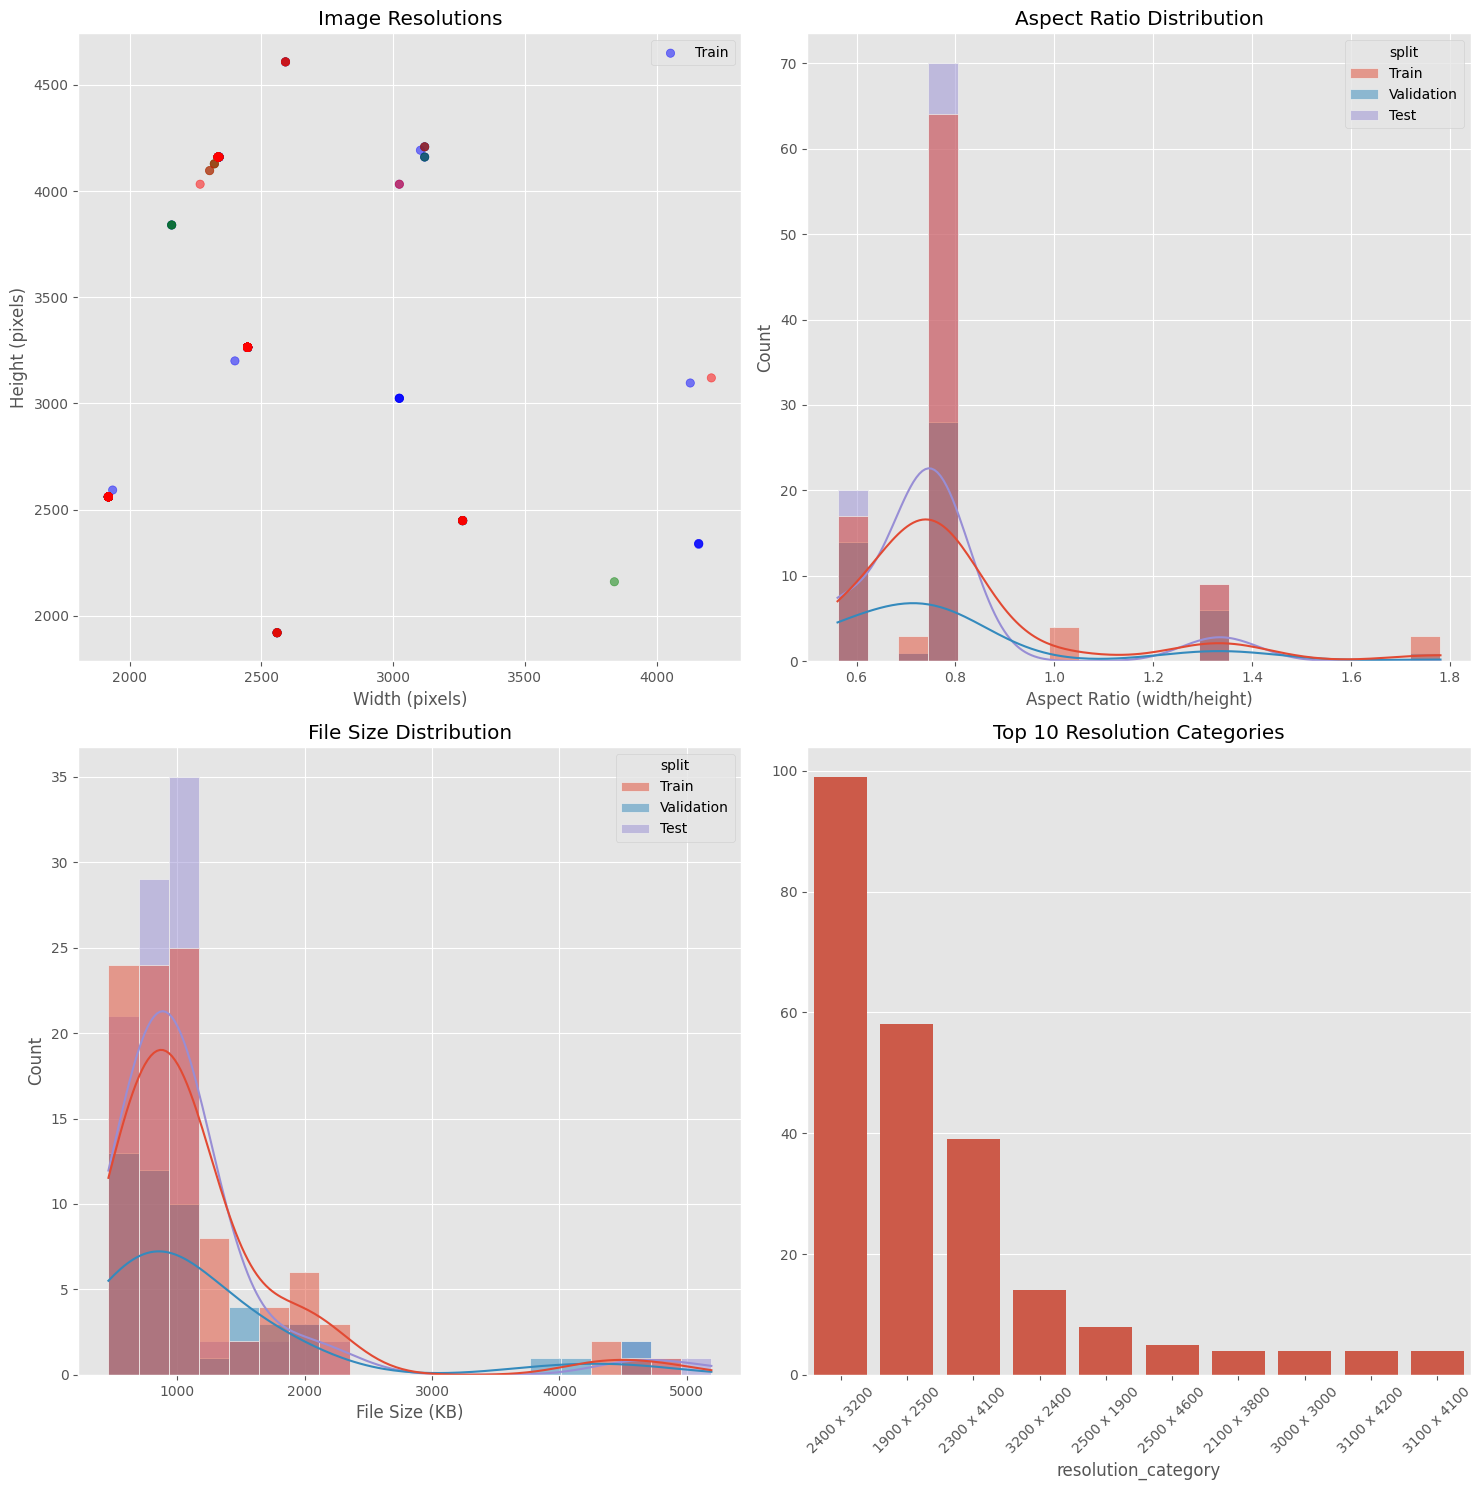


Image Property Summary Statistics:

Width (pixels):
count     250.000000
mean     2428.760000
std       442.313213
min      1920.000000
25%      2277.000000
50%      2448.000000
75%      2448.000000
max      4208.000000
Name: widths, dtype: float64

Height (pixels):
count     250.000000
mean     3212.160000
std       656.635191
min      1920.000000
25%      2560.000000
50%      3264.000000
75%      3264.000000
max      4608.000000
Name: heights, dtype: float64

Aspect Ratio:
count    250.000000
mean       0.787992
std        0.238024
min        0.561538
25%        0.750000
50%        0.750000
75%        0.750000
max        1.780822
Name: aspects, dtype: float64

File Size (KB):
count     250.000000
mean     1170.217531
std       858.123793
min       458.011719
25%       706.447266
50%       937.596680
75%      1141.961182
max      5192.890625
Name: file_sizes, dtype: float64


In [7]:
# Set plot style
plt.style.use('ggplot')
fig = plt.figure(figsize=(15, 15))

# Resolution distribution
plt.subplot(2, 2, 1)
plt.scatter(all_properties['widths'], all_properties['heights'], alpha=0.5, c=all_properties['split'].map({'Train': 'blue', 'Validation': 'green', 'Test': 'red'}))
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.title('Image Resolutions')
plt.grid(True)
plt.legend(['Train', 'Validation', 'Test'])

# Aspect ratio distribution
plt.subplot(2, 2, 2)
sns.histplot(data=all_properties, x='aspects', hue='split', kde=True, bins=20)
plt.xlabel('Aspect Ratio (width/height)')
plt.title('Aspect Ratio Distribution')

# Image size distribution
plt.subplot(2, 2, 3)
sns.histplot(data=all_properties, x='file_sizes', hue='split', kde=True, bins=20)
plt.xlabel('File Size (KB)')
plt.title('File Size Distribution')

# Resolution categories
plt.subplot(2, 2, 4)
# Create resolution categories
all_properties['resolution_category'] = all_properties.apply(
    lambda row: f"{int(row['widths']/100)}00 x {int(row['heights']/100)}00", axis=1
)
resolution_counts = all_properties['resolution_category'].value_counts().head(10)
sns.barplot(x=resolution_counts.index, y=resolution_counts.values)
plt.xticks(rotation=45)
plt.title('Top 10 Resolution Categories')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nImage Property Summary Statistics:")
print("\nWidth (pixels):")
print(all_properties['widths'].describe())
print("\nHeight (pixels):")
print(all_properties['heights'].describe())
print("\nAspect Ratio:")
print(all_properties['aspects'].describe())
print("\nFile Size (KB):")
print(all_properties['file_sizes'].describe())

### 8. Annotation Analysis

In [8]:
# Function to read and analyze annotation files
def analyze_annotations(labels_path, sample_size=100):
    # List all blobs in path
    blobs = list(bucket.list_blobs(prefix=labels_path))
    label_blobs = [blob for blob in blobs if not blob.name.endswith('/')]
    
    # Sample annotations if we have more than sample_size
    if len(label_blobs) > sample_size:
        sampled_blobs = random.sample(label_blobs, sample_size)
    else:
        sampled_blobs = label_blobs
    
    # Stats to collect
    objects_per_image = []
    all_bbox_widths = []
    all_bbox_heights = []
    all_bbox_areas = []
    
    # Analyze each annotation file
    for blob in tqdm(sampled_blobs, desc="Analyzing annotations"):
        # Download and parse annotation file
        content = blob.download_as_text()
        lines = content.strip().split('\n')
        
        # Count objects in this image
        num_objects = len(lines)
        objects_per_image.append(num_objects)
        
        # Process each bounding box
        for line in lines:
            try:
                parts = line.strip().split()
                # Assuming format is [class_id, x1, y1, x2, y2, score]
                # Adapt this based on your actual annotation format
                x1, y1, x2, y2 = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
                
                # Calculate bbox dimensions
                width = x2 - x1
                height = y2 - y1
                area = width * height
                
                all_bbox_widths.append(width)
                all_bbox_heights.append(height)
                all_bbox_areas.append(area)
            except (IndexError, ValueError) as e:
                print(f"Error parsing line: {line}")
                continue
    
    return {
        'objects_per_image': objects_per_image,
        'bbox_widths': all_bbox_widths,
        'bbox_heights': all_bbox_heights,
        'bbox_areas': all_bbox_areas
    }

# Analyze annotations from each split
print("Analyzing sample annotations from each split...")
train_annotations = analyze_annotations('SKU110K_Kaggle/labels/train/', sample_size=100)
val_annotations = analyze_annotations('SKU110K_Kaggle/labels/val/', sample_size=50)
test_annotations = analyze_annotations('SKU110K_Kaggle/labels/test/', sample_size=100)

Analyzing sample annotations from each split...


Analyzing annotations:   0%|          | 0/100 [00:00<?, ?it/s]

Analyzing annotations:   0%|          | 0/50 [00:00<?, ?it/s]

Analyzing annotations:   0%|          | 0/100 [00:00<?, ?it/s]

### 9. Visualize Annotation Statistics

/var/tmp/ipykernel_26824/484952477.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([all_areas['Train'], all_areas['Validation'], all_areas['Test']],
/var/tmp/ipykernel_26824/484952477.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_density, val_density, test_density],


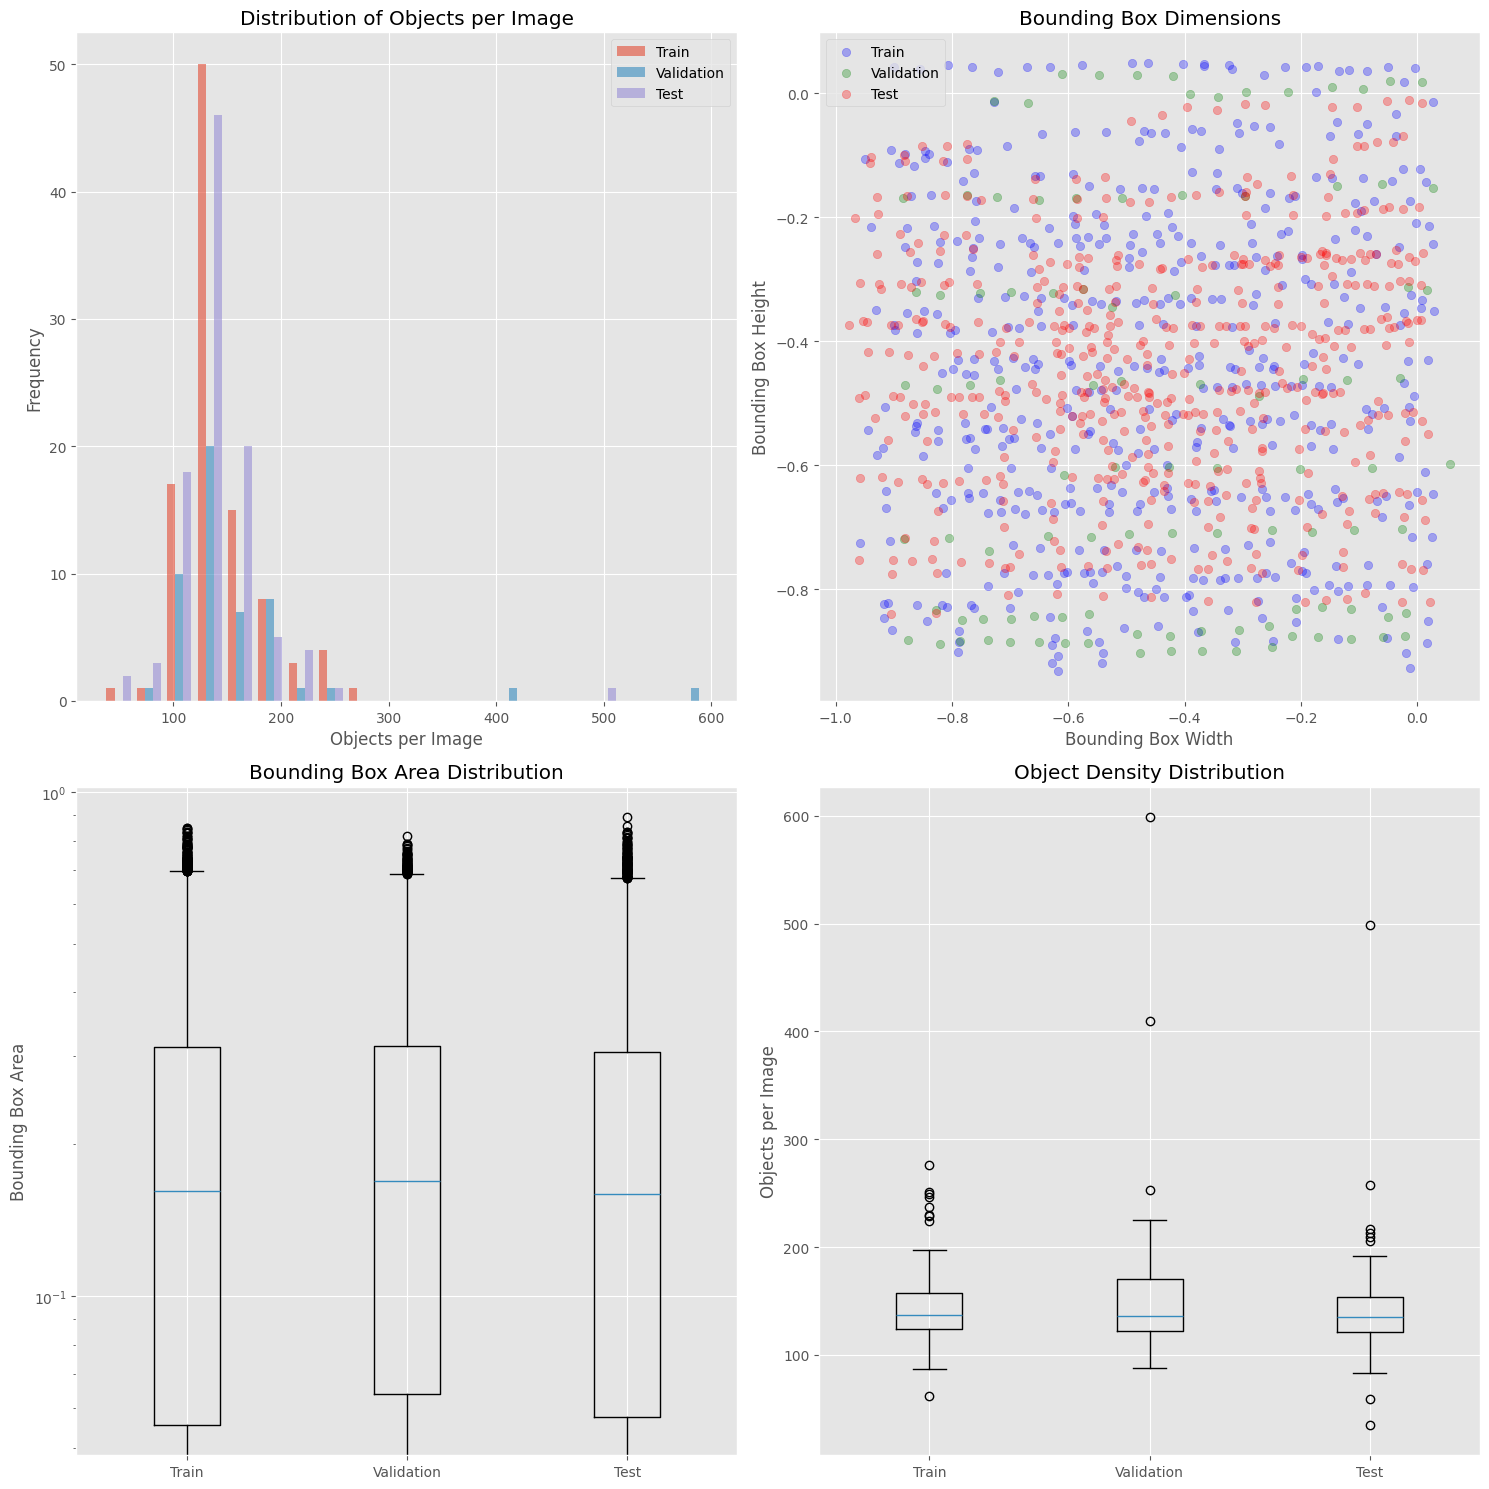


Annotation Summary Statistics:

Objects per Image:
count    250.000000
mean     146.992000
std       52.787137
min       35.000000
25%      122.000000
50%      136.000000
75%      155.750000
max      599.000000
dtype: float64

Average objects per image in Train: 145.21
Average objects per image in Validation: 159.96
Average objects per image in Test: 142.29


In [9]:
# Create visualization for annotation statistics
fig = plt.figure(figsize=(15, 15))

# Objects per image
plt.subplot(2, 2, 1)
train_obj_counts = pd.Series(train_annotations['objects_per_image'])
val_obj_counts = pd.Series(val_annotations['objects_per_image'])
test_obj_counts = pd.Series(test_annotations['objects_per_image'])

plt.hist([train_obj_counts, val_obj_counts, test_obj_counts], 
         bins=20, alpha=0.6, label=['Train', 'Validation', 'Test'])
plt.xlabel('Objects per Image')
plt.ylabel('Frequency')
plt.title('Distribution of Objects per Image')
plt.legend()

# Bounding box dimensions
plt.subplot(2, 2, 2)
plt.scatter(train_annotations['bbox_widths'][:500], train_annotations['bbox_heights'][:500], 
            alpha=0.3, label='Train', color='blue')
plt.scatter(val_annotations['bbox_widths'][:100], val_annotations['bbox_heights'][:100], 
            alpha=0.3, label='Validation', color='green')
plt.scatter(test_annotations['bbox_widths'][:500], test_annotations['bbox_heights'][:500], 
            alpha=0.3, label='Test', color='red')
plt.xlabel('Bounding Box Width')
plt.ylabel('Bounding Box Height')
plt.title('Bounding Box Dimensions')
plt.legend()

# Bounding box areas
plt.subplot(2, 2, 3)
# Combine all data
all_areas = {
    'Train': train_annotations['bbox_areas'],
    'Validation': val_annotations['bbox_areas'],
    'Test': test_annotations['bbox_areas']
}
plt.boxplot([all_areas['Train'], all_areas['Validation'], all_areas['Test']], 
            labels=['Train', 'Validation', 'Test'])
plt.ylabel('Bounding Box Area')
plt.title('Bounding Box Area Distribution')
plt.yscale('log')  # Log scale for better visualization

# Density of objects
plt.subplot(2, 2, 4)
# Calculate objects per unit area
train_density = [count for count in train_annotations['objects_per_image']]
val_density = [count for count in val_annotations['objects_per_image']]
test_density = [count for count in test_annotations['objects_per_image']]

plt.boxplot([train_density, val_density, test_density], 
            labels=['Train', 'Validation', 'Test'])
plt.ylabel('Objects per Image')
plt.title('Object Density Distribution')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nAnnotation Summary Statistics:")
print("\nObjects per Image:")
all_counts = train_annotations['objects_per_image'] + val_annotations['objects_per_image'] + test_annotations['objects_per_image']
print(pd.Series(all_counts).describe())

# Average objects per split
print(f"\nAverage objects per image in Train: {np.mean(train_annotations['objects_per_image']):.2f}")
print(f"Average objects per image in Validation: {np.mean(val_annotations['objects_per_image']):.2f}")
print(f"Average objects per image in Test: {np.mean(test_annotations['objects_per_image']):.2f}")

### 10. Create Distribution Report

In [10]:
# Create a comprehensive dataset report
report = pd.DataFrame({
    'Metric': [
        'Total Images',
        'Training Images',
        'Validation Images',
        'Test Images',
        'Training Split %',
        'Validation Split %',
        'Test Split %',
        'Avg. Image Width (px)',
        'Avg. Image Height (px)',
        'Avg. Aspect Ratio',
        'Avg. File Size (KB)',
        'Avg. Objects per Image',
        'Max Objects in an Image',
        'Min Objects in an Image',
        'Avg. Bounding Box Area',
        'Total Bounding Boxes Analyzed'
    ],
    'Value': [
        total_images,
        train_count,
        val_count,
        test_count,
        f"{train_percent:.2f}%",
        f"{val_percent:.2f}%",
        f"{test_percent:.2f}%",
        f"{all_properties['widths'].mean():.2f}",
        f"{all_properties['heights'].mean():.2f}",
        f"{all_properties['aspects'].mean():.2f}",
        f"{all_properties['file_sizes'].mean():.2f}",
        f"{np.mean(all_counts):.2f}",
        max(all_counts),
        min(all_counts),
        f"{np.mean(train_annotations['bbox_areas'] + val_annotations['bbox_areas'] + test_annotations['bbox_areas']):.2f}",
        len(train_annotations['bbox_areas']) + len(val_annotations['bbox_areas']) + len(test_annotations['bbox_areas'])
    ]
})

# Display report
print("\nSKU-110K Dataset Analysis Report")
print("================================")
print(report.to_string(index=False))

# Save report
report.to_csv('sku110k_dataset_analysis.csv', index=False)
print("\nReport saved to 'sku110k_dataset_analysis.csv'")


SKU-110K Dataset Analysis Report
                       Metric   Value
                 Total Images   11689
              Training Images    8185
            Validation Images     584
                  Test Images    2920
             Training Split %  70.02%
           Validation Split %   5.00%
                 Test Split %  24.98%
        Avg. Image Width (px) 2428.76
       Avg. Image Height (px) 3212.16
            Avg. Aspect Ratio    0.79
          Avg. File Size (KB) 1170.22
       Avg. Objects per Image  146.99
      Max Objects in an Image     599
      Min Objects in an Image      35
       Avg. Bounding Box Area    0.20
Total Bounding Boxes Analyzed   36748

Report saved to 'sku110k_dataset_analysis.csv'


### 11. Visualize a Few Sample Images

Found annotation for train_900.jpg
First 3 annotations (of 123):
  0 0.8241421568627451 0.5268075980392157 0.13031045751633988 0.04932598039215686
  0 0.9303513071895425 0.53125 0.056781045751633986 0.049019607843137254
  0 0.16176470588235295 0.6193321078431373 0.04084967320261438 0.0389093137254902
Box 1: x1=0.0, y1=0.8241421568627451, x2=0.5268075980392157, y2=0.13031045751633988
Box 2: x1=0.0, y1=0.9303513071895425, x2=0.53125, y2=0.056781045751633986
Box 3: x1=0.0, y1=0.16176470588235295, x2=0.6193321078431373, y2=0.04084967320261438
Drew 123 boxes for train_900.jpg
Found annotation for train_2894.jpg
First 3 annotations (of 175):
  0 0.5768229166666666 0.4927734375 0.06927083333333334 0.025390625
  0 0.5065104166666666 0.4923828125 0.0671875 0.027734375
  0 0.5046875 0.463671875 0.071875 0.025
Box 1: x1=0.0, y1=0.5768229166666666, x2=0.4927734375, y2=0.06927083333333334
Box 2: x1=0.0, y1=0.5065104166666666, x2=0.4923828125, y2=0.0671875
Box 3: x1=0.0, y1=0.5046875, x2=0.463671875

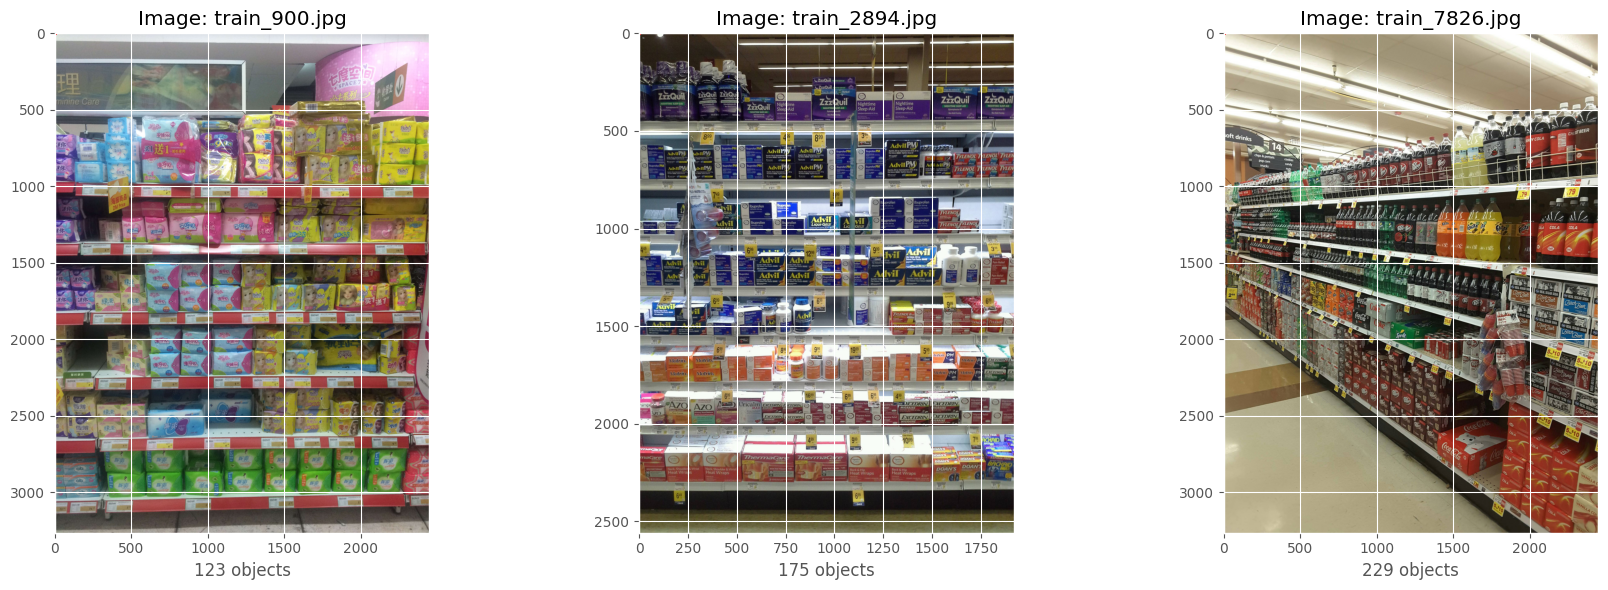

In [11]:
def visualize_sample_images(count=3):
    """
    Visualize sample images with their corresponding annotations
    from the SKU-110K dataset stored in GCS.
    """
    # Set up the figure
    fig, axes = plt.subplots(1, count, figsize=(18, 6))
    if count == 1:
        axes = [axes]
    
    # Get sample images from the training set
    image_blobs = list(bucket.list_blobs(prefix='SKU110K_Kaggle/images/train/'))
    image_files = [b for b in image_blobs if b.name.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Process one sample image at a time
    for i, image_blob in enumerate(random.sample(image_files, min(count, len(image_files)))):
        # Extract image name and ID
        image_name = os.path.basename(image_blob.name)
        image_id = os.path.splitext(image_name)[0]
        
        # Corresponding annotation file path
        annotation_path = f'SKU110K_Kaggle/labels/train/{image_id}.txt'
        annotation_blob = bucket.blob(annotation_path)
        
        # Download and display the image
        image_data = image_blob.download_as_bytes()
        img = Image.open(io.BytesIO(image_data))
        img_array = np.array(img)
        
        axes[i].imshow(img_array)
        axes[i].set_title(f"Image: {image_name}")
        
        # Check if annotation exists
        if annotation_blob.exists():
            print(f"Found annotation for {image_name}")
            # Download annotations
            annotation_text = annotation_blob.download_as_text()
            boxes = annotation_text.strip().split('\n')
            
            # Print first few boxes for debugging
            print(f"First 3 annotations (of {len(boxes)}):")
            for box_sample in boxes[:3]:
                print(f"  {box_sample}")
            
            # Draw each bounding box
            boxes_drawn = 0
            for box in boxes:
                parts = box.strip().split()
                try:
                    # SKU-110K format is typically: x1 y1 x2 y2 confidence
                    if len(parts) >= 5:
                        x1, y1, x2, y2 = map(float, parts[:4])
                        
                        # Print coordinates for first few boxes
                        if boxes_drawn < 3:
                            print(f"Box {boxes_drawn+1}: x1={x1}, y1={y1}, x2={x2}, y2={y2}")
                        
                        # Create rectangle with more visible styling
                        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                           fill=False, edgecolor='red', linewidth=2)
                        axes[i].add_patch(rect)
                        boxes_drawn += 1
                        
                except Exception as e:
                    print(f"Error parsing annotation: {box}, Error: {str(e)}")
                    continue
            
            axes[i].set_xlabel(f"{boxes_drawn} objects")
            print(f"Drew {boxes_drawn} boxes for {image_name}")
        else:
            print(f"No annotation found for {image_name}")
            axes[i].set_xlabel("No annotations found")
        
        # Make sure axis is set properly
        axes[i].axis('on')  # Try with axis on to see if rectangles are outside view
    
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_sample_images(count=3)